In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

import math

import datetime
from datetime import date
from datetime import timedelta
import time

import warnings

C:\Users\Jenna\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
warnings.filterwarnings("ignore")

In [3]:
# DEBUG = True
DEBUG = False

# Data Ingestion

### Load Training Data

In [4]:
if not DEBUG:
    df_train = pd.read_csv(
        'train.csv', usecols=[1, 2, 3, 4, 5],
        dtype={'onpromotion': bool},
        converters={'unit_sales': lambda u: np.log1p(float(u)) if float(u) > 0 else 0},
        parse_dates=["date"],
        skiprows=range(1, 111007527)  # Only Include 2017-01-01
    )

In [5]:
if DEBUG:
    df_train = pd.read_csv('df_20170401.csv',
                           usecols=[0, 1, 2, 3, 4],
                           dtype={'onpromotion': bool},
                           parse_dates=["date"])

### Load Test Data

In [6]:
df_test = pd.read_csv("test.csv", usecols=[0, 1, 2, 3, 4],
                      dtype={'onpromotion': bool},
                      parse_dates=["date"])

### Load Item Data 

In [7]:
items = pd.read_csv("items.csv")
items.head(3)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0


# Data Exploration 

### Show Number of Stores in `Train` and `Test` Data Set

In [8]:
num_store_train = df_train['store_nbr'].drop_duplicates().shape[0]
num_store_test = df_test['store_nbr'].drop_duplicates().shape[0]

print("Num of Stores in Train Data Set: {}".format(num_store_train))
print("Num of Stores in Test Data Set: {}".format(num_store_test))

Num of Stores in Train Data Set: 54
Num of Stores in Test Data Set: 54


#### Show Number of Items in `Train`, `Test` and `Item` Data Set

In [9]:
num_item_train = df_train['item_nbr'].drop_duplicates().shape[0]
num_item_test = df_test['item_nbr'].drop_duplicates().shape[0]
num_item = items['item_nbr'].drop_duplicates().shape[0]

print("Num of Items in Train Data Set: {}".format(num_item_train))
print("Num of Items in Test Data Set: {}".format(num_item_test))
print("Num of Items in Item Data Set: {}".format(num_item))

Num of Items in Train Data Set: 3989
Num of Items in Test Data Set: 3901
Num of Items in Item Data Set: 4100


#### How Many Common Items in Both Training and Test Data Set

In [10]:
num_common_items = len(set(df_train['item_nbr'].drop_duplicates()) & set(df_test['item_nbr'].drop_duplicates()))
print("Num of Common Items: {}".format(num_common_items))

Num of Common Items: 3841


#### How Many Item Categories in `Item` Data

In [11]:
num_item_category = items['family'].drop_duplicates().shape[0]
print("Num of Items Category in Item Data Set: {}".format(num_item_category))

Num of Items Category in Item Data Set: 33


#### Show Perishable Item Categories

In [12]:
item_category = items[['family', 'perishable']].drop_duplicates()
item_category[item_category['perishable']==1]

,family,perishable
4,BREAD/BAKERY,1
15,DELI,1
20,POULTRY,1
21,EGGS,1
54,DAIRY,1
132,MEATS,1
198,SEAFOOD,1
237,PREPARED FOODS,1
1709,PRODUCE,1


#### Show Perishable Item Categories

In [13]:
item_category_percentage = item_category.groupby('perishable').count()
item_category_percentage = item_category_percentage.reset_index()

In [14]:
item_category_percentage

,perishable,family
0,0,24
1,1,9


In [15]:
mapper = {
    1: 'perishable', 
    0: 'non-perishable'
}

item_category_percentage = item_category_percentage.applymap(lambda s: mapper.get(s) if s in mapper else s)

In [16]:
item_category_percentage

,perishable,family
0,non-perishable,24
1,perishable,9


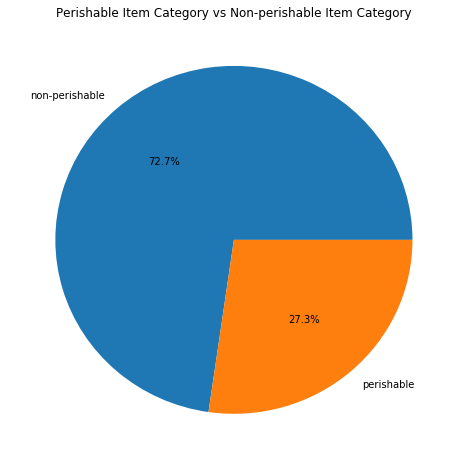

In [17]:
fig, axs = plt.subplots(figsize=(8, 8))
plt.title("Perishable Item Category vs Non-perishable Item Category")
axs.pie(item_category_percentage['family'], labels=item_category_percentage['perishable'], autopct='%1.1f%%')
plt.show()

#### Show Percentage of Promotions

In [18]:
percentage_promo = df_train[df_train['onpromotion']==True].shape[0] / df_train.shape[0]
print("Percentage of Promotions: {:.1%}".format(percentage_promo))

Percentage of Promotions: 12.1%


# Data Wrangling

#### Pivot the dataset so that it has dates as the columns

In [19]:
def pivot_data (df, values, ind, col, fill_value):
    '''
    Parameters
    ----------
    value : the columns to be aggregated
    ind : index
    col : the existing in to be set as column
    
    Returns: Pivot table of df
    '''
    df = df.set_index(ind + col)[values].unstack(level = -1).fillna(fill_value)
    
    # Unstack will create multi-layer hiarachical columns, only use the level 1 column which is col
    df.columns = df.columns.get_level_values(1)
    
    return df

In [20]:
df_train.head(2)

,date,store_nbr,item_nbr,unit_sales,onpromotion
0,2017-04-01,1,103520,0.693147,False
1,2017-04-01,1,103665,0.693147,False


In [21]:
df_train_promo = pivot_data (df_train, ['onpromotion'], ['store_nbr','item_nbr'], ['date'], False )
df_test_promo = pivot_data (df_test, ['onpromotion'], ['store_nbr','item_nbr'], ['date'], False )
df_train_sales = pivot_data (df_train, ['unit_sales'], ['store_nbr','item_nbr'], ['date'], 0)

In [22]:
df_train_sales.head(2)

date                2017-04-01  2017-04-02  2017-04-03  2017-04-04  \
store_nbr item_nbr                                                   
1         96995            0.0         0.0         0.0         0.0   
          99197            0.0         0.0         0.0         0.0   

date                2017-04-05  2017-04-06  2017-04-07  2017-04-08  \
store_nbr item_nbr                                                   
1         96995            0.0         0.0    1.098612         0.0   
          99197            0.0         0.0    0.000000         0.0   

date                2017-04-09  2017-04-10     ...      2017-08-06  \
store_nbr item_nbr                             ...                   
1         96995            0.0         0.0     ...        1.098612   
          99197            0.0         0.0     ...        0.000000   

date                2017-08-07  2017-08-08  2017-08-09  2017-08-10  \
store_nbr item_nbr                                                   
1         96995       1.098612         0.0    0.000000    0.693147   
          99197       1.098612         0.0    1.098612    0.000000   

date                2017-08-11  2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                              
1         96995            0.0         0.0         0.0         0.0         0.0  
          99197            0.0         0.0         0.0         0.0         0.0  

[2 rows x 137 columns]

#### min-max normalization of the unit_sales data in the training set

In [23]:
#sub_min = df_train_sales.sub(df_train_sales.min(axis=1), axis=0)
#max_min = df_train_sales.max(axis=1) - df_train_sales.min(axis=1)
#df_train_sales = sub_min.divide(max_min,axis=0)

#### Unifying the index of test and train promo

In [24]:
df_test_promo = df_test_promo.reindex(df_train_promo.index, fill_value = False)
items = items.set_index("item_nbr").reindex(df_train_sales.index.get_level_values(1))

### Concatenate Promo Train and Test Data Set

In [25]:
df_promo = pd.concat([df_train_promo, df_test_promo], axis = 1)

In [26]:
df_promo.head(2)

date                2017-04-01  2017-04-02  2017-04-03  2017-04-04  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   

date                2017-04-05  2017-04-06  2017-04-07  2017-04-08  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   

date                2017-04-09  2017-04-10     ...      2017-08-22  \
store_nbr item_nbr                             ...                   
1         96995          False       False     ...           False   
          99197          False       False     ...           False   

date                2017-08-23  2017-08-24  2017-08-25  2017-08-26  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   

date                2017-08-27  2017-08-28  2017-08-29  2017-08-30  2017-08-31  
store_nbr item_nbr                                                              
1         96995          False       False       False       False       False  
          99197          False       False       False       False       False  

[2 rows x 153 columns]

# Feature Engineering

In [27]:
# Generate past n days' date index range
def past_date_range_index(day, n_days):
    date_index = pd.date_range(day - timedelta(days=n_days), 
                               day, 
                               closed='left')
    return date_index

In [28]:
# Generate past nth day's date index
def past_date_index (day,n_days):
    date_index = day - timedelta(days = n_days)
    return date_index

#### Generate feature, target and promo set

In [29]:
def feature_generation(df_sales, df_promo, pred_date, target_on):

    # Generate the date range starting from the pred_date
    future_date_range = pd.date_range(pred_date, periods=16)

    # Create empty feature set
    features = pd.DataFrame()

    period=[3, 4, 5, 6, 7, 14, 21]
    for n_days in period:
        
        # Feature Type 1: Past n Days' Sales Mean
        date_index = past_date_range_index(pred_date, n_days)
        features['past_{}day_mean'.format(n_days)] =  df_sales[date_index].mean(axis=1)
 
        # Feature Type 2: Past n Days' Sales Decaying Sum (Exponential). 
        # Decaying factor = 0.9 
        df_tmp1 = df_sales[date_index]
        features['past_{}day_sum_decay'.format(n_days)] = \
          (df_tmp1 * np.power(0.9, np.arange(n_days)[::-1])).sum(axis=1)
    

    # Feature Type 3: Past nth Day Sales
    period = [1, 2, 3, 4, 5, 6, 7]
    for n_day in period:
        date_index = past_date_index(pred_date, n_day)
        features['past_{}th_day'.format(n_day)] =  df_sales[date_index]   

        
    # Feature Type 4: Past n days' Total Number of Promotion of Each Item
    period=[3, 4, 5, 6, 7, 14, 21]
    for n_days in period:
        date_index = past_date_range_index(pred_date, n_days)
        features['Past_{}day_tot_promo'.format(n_days)] =  df_promo[date_index].sum(axis=1) 

    # Feature Type 5: Future Promotion      
    mapper = {
        True: 1, 
        False: 0
    }
    future_promo = df_promo[future_date_range].applymap(lambda s: mapper.get(s) if s in mapper else False)

    # For generating test data, no target is returned.
    if target_on:
        target = df_sales[future_date_range]
        
        return features,target, future_promo
   
    return features, future_promo


### Train, Validation, Test Date preparation

#### Select one `Boundary Day` for each `training`, `validation` and `test` data  

In [30]:
train_date = datetime.datetime(2017, 7, 5)
val_date = datetime.datetime (2017, 7, 12)
test_date = datetime.datetime (2017, 8, 16)

#### Generate `Training` data set  

In [31]:
feature_train, target_train, future_promo_train = \
   feature_generation(df_train_sales,
                      df_promo,
                      train_date,
                      True)

#### Generate `Validation` data set  

In [32]:
feature_val, target_val, future_promo_val = \
   feature_generation(df_train_sales,
                      df_promo,
                      val_date,
                      True)

#### Generate `Test` data set  

In [33]:
feature_test, future_promo_test = \
   feature_generation(df_train_sales,
                      df_promo,
                      test_date,
                      False)

#### Generate weight matrix for perishable items

In [34]:
weight_matrix = np.array(items['perishable']) * 0.25 + 1

# Model Building
Training one model per prediciton date, total 16 models will be trained for each method

In [35]:
n_pred_days = 16

## Method 1. Random Forest Regression (RFR)
#### Training

In [36]:
start = time.time()

if DEBUG:
    n_estimators_ = 1
else:
    n_estimators_ = 10
    
model_RF_all = [] # Model list for storing all 16 models
feature_train_add = pd.DataFrame()
feature_val_add = pd.DataFrame()
feature_test_add = pd.DataFrame()

# future_promo contains 16 days data, get the one on prediction date and use as a feature

for i in range(n_pred_days): 
    
    print("=" * 50)
    print('Training Random Forest Regression Model #{} ...'.format(i))

    feature_train_add = pd.concat([feature_train,future_promo_train.iloc[:,i]], axis=1)
    feature_val_add = pd.concat([feature_val,future_promo_val.iloc[:,i]], axis=1)
    feature_test_add = pd.concat([feature_test,future_promo_test.iloc[:,i]], axis=1)
    
    model = RandomForestRegressor(n_estimators = n_estimators_, random_state = 50)
    model = model.fit(feature_train_add, target_train.iloc[:,i])

    model_RF_all.append(model)

    print("")
    
end = time.time()
print ("Time of Training {} Random Forest Regression Models: {:.2f} Mins".format(n_pred_days, (end - start) / 60))    

Training Random Forest Regression Model #0 ...

Training Random Forest Regression Model #1 ...

Training Random Forest Regression Model #2 ...

Training Random Forest Regression Model #3 ...

Training Random Forest Regression Model #4 ...

Training Random Forest Regression Model #5 ...

Training Random Forest Regression Model #6 ...

Training Random Forest Regression Model #7 ...

Training Random Forest Regression Model #8 ...

Training Random Forest Regression Model #9 ...

Training Random Forest Regression Model #10 ...

Training Random Forest Regression Model #11 ...

Training Random Forest Regression Model #12 ...

Training Random Forest Regression Model #13 ...

Training Random Forest Regression Model #14 ...

Training Random Forest Regression Model #15 ...

Time of Training 16 Random Forest Regression Models: 8.06 Mins


#### Analyzing Feature Importance

In [37]:
for i in range(n_pred_days):
    print("=" * 50)
    print ('Feature Importance Report [Random Forest Model #{}]'.format(i))
    
    feature_train_add = feature_train.copy()
    feature_train_add['predict_day_promo']= future_promo_train.iloc[:,i]
    
    feature_importance = pd.DataFrame(
        sorted(zip(feature_train_add.columns, model_RF_all[i].feature_importances_ ),
        key=lambda x: x[1], reverse=True), columns = ['feature','gain']
    )
    
    print(feature_importance.to_string())
    print("")

Feature Importance Report [Random Forest Model #0]
                 feature      gain
0   past_21day_sum_decay  0.630298
1   past_14day_sum_decay  0.076320
2        past_21day_mean  0.025816
3        past_14day_mean  0.022246
4         past_7day_mean  0.021614
5      predict_day_promo  0.020341
6    past_7day_sum_decay  0.016750
7    past_6day_sum_decay  0.012885
8           past_1th_day  0.012540
9    past_3day_sum_decay  0.012440
10   past_5day_sum_decay  0.012347
11          past_3th_day  0.012111
12   past_4day_sum_decay  0.012067
13          past_7th_day  0.011893
14          past_2th_day  0.011306
15          past_4th_day  0.011294
16        past_6day_mean  0.010915
17        past_5day_mean  0.010333
18        past_4day_mean  0.009667
19          past_5th_day  0.009584
20          past_6th_day  0.008888
21        past_3day_mean  0.008281
22  Past_21day_tot_promo  0.004618
23   Past_6day_tot_promo  0.004272
24   Past_7day_tot_promo  0.003902
25  Past_14day_tot_promo  0.003795
26  

                 feature      gain
0   past_21day_sum_decay  0.381578
1        past_21day_mean  0.253468
2      predict_day_promo  0.035229
3        past_14day_mean  0.028886
4   past_14day_sum_decay  0.025979
5    past_7day_sum_decay  0.018536
6         past_7day_mean  0.017715
7           past_3th_day  0.017439
8    past_6day_sum_decay  0.016318
9    past_5day_sum_decay  0.015689
10          past_2th_day  0.015631
11          past_4th_day  0.014909
12   past_3day_sum_decay  0.014872
13   past_4day_sum_decay  0.014755
14        past_6day_mean  0.014518
15          past_1th_day  0.014086
16          past_6th_day  0.013975
17        past_5day_mean  0.013586
18          past_7th_day  0.013417
19          past_5th_day  0.013066
20        past_4day_mean  0.012745
21        past_3day_mean  0.010818
22  Past_21day_tot_promo  0.007405
23  Past_14day_tot_promo  0.006284
24   Past_7day_tot_promo  0.003078
25   Past_6day_tot_promo  0.001789
26   Past_4day_tot_promo  0.001568
27   Past_5day_tot_p

#### Model Prediction 

In [38]:
def predict_all(models, feature, future_promo, start_date):
    target_predic_all = {}
    future_date_range = pd.date_range(start_date, periods=16) 
    
    length = len(models) 
    for i in range (length):   
        feature_add = pd.concat([feature,future_promo.iloc[:,i]], axis=1)
        target_predic = models[i].predict(feature_add)
 
        if len(target_predic.shape) == 2:
            target_predic = target_predic[:,0]
        
        target_predic_all[future_date_range[i]] = target_predic
        target_predic_all = pd.DataFrame(target_predic_all)
    
    return target_predic_all

In [39]:
predict_val_all_RF = predict_all(model_RF_all, feature_val, future_promo_val, val_date)
predict_test_all_RF = predict_all(model_RF_all, feature_test, future_promo_test, test_date)

#### Define Model Performance Metric

In [40]:
def nwrmsle_cal(predict, actual, weight):
    #predict = predict.values
    #actual = actual.values
    
    error = (actual - np.array(predict)) ** 2
    error = error.sum(axis=1) * weight
    nwrmsle = np.sqrt(error.sum() / weight.sum() / 16)
                  
    return nwrmsle

In [41]:
def smape_cal(train, predict, target, dates):
    y = np.array(predict)
    forcast = pd.DataFrame(
    y, index=train.index,
    columns=pd.date_range(dates, periods=16)).stack().to_frame("predict_unit_sales")
    
    forcast.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)
    
    forcast["predict_unit_sales"] = np.expm1(forcast["predict_unit_sales"])
    
    actual = target.stack().to_frame("actual_unit_sales")
    actual.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)
    actual["actual_unit_sales"] = np.expm1(actual["actual_unit_sales"])
    
    concat_data = pd.concat([actual,forcast], axis=1)
    concat_data = concat_data[(concat_data['actual_unit_sales'] !=0 )|(concat_data['predict_unit_sales'] != 0)]
    
    
    a = concat_data['actual_unit_sales'].values
    f = concat_data['predict_unit_sales'].values
    smape = np.mean(abs(a - f) / (abs(a) + abs(f)) / 2) * 100
    
    return smape

#### Performance Evaluation

In [42]:
nwrmsle_val_RF = nwrmsle_cal(predict_val_all_RF, target_val, weight_matrix )
rmse_val_RF = math.sqrt(mean_squared_error(predict_val_all_RF.values, target_val.values))
smape_val_RF = smape_cal(df_train_sales, predict_val_all_RF, target_val, val_date)

In [43]:
print('NWRMSLE on Validation Data Set [Random Forest Regression]: {:.3f}'.format(nwrmsle_val_RF))
print('RMSLE on Validation Data Set [Random Forest Regression]: {:.3f}'.format(rmse_val_RF))
print('sMAPE on Validation Data Set [Random Forest Regression]: {:.1f}%'.format(smape_val_RF))

NWRMSLE on Validation Data Set [Random Forest Regression]: 0.657
RMSLE on Validation Data Set [Random Forest Regression]: 0.657
sMAPE on Validation Data Set [Random Forest Regression]: 28.3%


## Method 2. Deep Learning Model (DL)

#### Define Network Architecture

In [44]:
def model_creation(input_dim_, dropout_rate=0.0):
    # Set Initial Weights 
    kernel_initializer_ = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=1)
    
    # Define Netwrok Type
    model = Sequential()
    
    # Hidden layer
    model.add(Dense(32, activation='relu', input_shape=(input_dim_,),kernel_initializer=kernel_initializer_))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(16, activation='relu', kernel_initializer=kernel_initializer_))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(8, activation='relu', kernel_initializer=kernel_initializer_))
    
    # Output layer
    model.add(Dense(1, activation='relu', kernel_initializer=kernel_initializer_))
    
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model
    

#### Define Training Function

In [45]:
def model_training_dl(feature_train, target_train, feature_val, target_val, epochs_):
    input_dim = feature_train.shape[1]
           
    # Define Call Back for Early Stop
    call_back = [
        keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto')
    ]
       
    # Initialize Model
    model = model_creation(input_dim)
    
    # Train DLModel
    model_info = model.fit(feature_train, 
                           target_train,
                           batch_size=feature_train.shape[0],
                           epochs=epochs_,
                           verbose=0,
                           callbacks = call_back,
                           validation_data=(feature_val, target_val)
                          )
    return model, model_info

#### Training

In [ ]:
if DEBUG:
    epochs_ = 2
else:
    epochs_ = 1000
    
model_dl_all = [] # Model list for storing all 16 models
model_info_dl_all= [] # List of storing model training information, such as val_loos, val_acc. 

feature_train_add = pd.DataFrame()
feature_val_add = pd.DataFrame()
feature_test_add = pd.DataFrame()

start = time.time()

# future_promo contains 16 days data, get the one on prediction date and use as a feature

for i in range(n_pred_days): 
    
    print("=" * 50)
    print('Training Deep Learning Model #{} ...'.format(i))
    
    feature_train_add = pd.concat([feature_train,future_promo_train.iloc[:,i]], axis=1)
    feature_val_add = pd.concat([feature_val,future_promo_val.iloc[:,i]], axis=1)
    feature_test_add = pd.concat([feature_test,future_promo_test.iloc[:,i]], axis=1)
    

    model_dl, model_info_dl = model_training_dl(feature_train_add,
                                                target_train.iloc[:,i], 
                                                feature_val_add,
                                                target_val.iloc[:,i],
                                                epochs_)  
    model_dl_all.append(model_dl)
    model_info_dl_all.append(model_info_dl)
    print("")
    
end = time.time()
print ("Time of Training {} Deep Learning Models: {:.2f} Mins".format(n_pred_days, (end - start) / 60))

Training Deep Learning Model #0 ...

Training Deep Learning Model #1 ...

Training Deep Learning Model #2 ...

Training Deep Learning Model #3 ...

Training Deep Learning Model #4 ...

Training Deep Learning Model #5 ...

Training Deep Learning Model #6 ...

Training Deep Learning Model #7 ...


#### Model Prediction 

In [ ]:
predict_val_all_DL = predict_all(model_dl_all, feature_val, future_promo_val, val_date)
predict_test_all_DL = predict_all(model_dl_all, feature_test, future_promo_test, test_date)

#### Performance Evaluation

In [ ]:
nwrmsle_val_DL = nwrmsle_cal(predict_val_all_DL, target_val, weight_matrix )
rmse_val_DL = math.sqrt(mean_squared_error(predict_val_all_DL.values, target_val.values))
smape_val_DL = smape_cal(df_train_sales, predict_val_all_DL, target_val, val_date)

In [ ]:
print('NWRMSLE on Validation Data Set [DL]: {:.3f}'.format(nwrmsle_val_DL))
print('RMSLE on Validation Data Set [DL]: {:.3f}'.format(rmse_val_DL))
print('sMAPE on Validation Data Set [DL]: {:.1f}%'.format(smape_val_DL))

## Method 3. LGBM Model

#### Training

In [ ]:
model_LGBM_all = [] # Model list for storing all 16 models

feature_train_add = pd.DataFrame()
feature_val_add = pd.DataFrame()
feature_test_add = pd.DataFrame()

start = time.time()

# future_promo contains 16 days data, get the one on prediction date and use as a feature

for i in range(n_pred_days): 
    
    print("=" * 50)
    print('Training LGBM Model {} ...'.format(i))

    feature_train_add = pd.concat([feature_train,future_promo_train.iloc[:,i]], axis=1)
    feature_val_add = pd.concat([feature_val,future_promo_val.iloc[:,i]], axis=1)
    feature_test_add = pd.concat([feature_test,future_promo_test.iloc[:,i]], axis=1)

    
    d_train = lgb.Dataset(
        feature_train_add, label = target_train.iloc[:,i],
        weight =  weight_matrix
    )
    
    
    d_val = lgb.Dataset(
        feature_val_add, label = target_val.iloc[:,i],
        reference = d_train,
        weight =  weight_matrix
    )
    
    # Set Up GBM Hyperparameter
    params = {}
    params['learning_rate'] = 0.05
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'regression_l2'
    params['metric'] = 'l2'
    params['num_leaves'] = 80
    params['max_depth'] = 8
    params['min_data_in_leaf'] = 200
    params['feature_fraction'] = 0.75
    params[ 'bagging_fraction'] = 0.75
    params[ 'bagging_freq'] = 1
    params[ 'num_threads'] = 4

    n_round = 1000

    model = lgb.train(
        params, 
        d_train, 
        num_boost_round=n_round,
        valid_sets=[d_train, d_val], 
        early_stopping_rounds=100, 
        verbose_eval=100
    )
    
    model_LGBM_all.append(model)
    print("")
    
end = time.time()
print ("Time of Training {} LGBM Models: {:.2f} Mins".format(n_pred_days, (end - start) / 60))

#### Analyzing Feature Importance

In [ ]:
for i in range(0, len(model_LGBM_all)):
    
    print("=" * 50)
    print ('Feature Importance Report [LGBM #{}]'.format(i))
    
    feature_train_add = feature_train.copy()
    feature_train_add['predict_day_promo'] = future_promo_train.iloc[:,i]
    
    feature_importance = pd.DataFrame(
        sorted(zip(feature_train_add.columns, model_LGBM_all[i].feature_importance("gain")),
               key=lambda x: x[1], reverse=True), columns = ['feature', 'gain']
    )
    
    print(feature_importance.to_string())
    print("")

#### Model Prediction 

In [ ]:
def predict_all_LGBM (models, feature,future_promo, start_date):
    target_predic_all = {}
    future_date_range = pd.date_range(start_date, periods=16)
    
    length = len(models) 
    for i in range (0, length):   
        feature_add = pd.concat([feature,future_promo.iloc[:,i]], axis=1)
        target_predic = models[i].predict(feature_add,num_iteration=models[i].best_iteration)
        target_predic_all[future_date_range[i]] = target_predic
        target_predic_all = pd.DataFrame(target_predic_all)
    
    return target_predic_all
    

In [ ]:
predict_val_all_LGBM = predict_all_LGBM (model_LGBM_all, feature_val, future_promo_val, val_date)
predict_test_all_LGBM = predict_all_LGBM (model_LGBM_all, feature_test, future_promo_test, test_date)

#### Model Performance Evaluation

In [ ]:
nwrmsle_val_LGBM = nwrmsle_cal(predict_val_all_LGBM, target_val, weight_matrix )
rmse_val_LGBM =math.sqrt(mean_squared_error(predict_val_all_LGBM.values, target_val.values))
smape_val_LGBM = smape_cal(df_train_sales, predict_val_all_LGBM, target_val, val_date)

In [ ]:
print('NWRMSLE on Validation Data Set [LGBM]: {:.3f}'.format(nwrmsle_val_LGBM))
print('RMSLE on Validation Data Set [LGBM]: {:.3f}'.format(rmse_val_LGBM))
print('sMAPE on Validation Data Set [LGBM]: {:.1f}%'.format(smape_val_LGBM))

## Data Submission
#### Change Back from Logrithmic Scale to Linear Scale

In [ ]:
y_test = np.array(predict_test_all_LGBM)

df_predict = pd.DataFrame(
    y_test, 
    index=df_train_sales.index,
    columns=pd.date_range(test_date, periods=16)
).stack().to_frame("unit_sales")

df_predict.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)
df_test.set_index(["store_nbr", "item_nbr", "date"], inplace=True)

df_sub = df_test[['id']].join(df_predict, how="left").fillna(0)
df_sub["unit_sales"] = np.expm1(df_sub["unit_sales"])

#### Save Prediction Output

In [ ]:
df_sub.to_csv('Submission.csv',index=None)